<a href="https://colab.research.google.com/github/IgorBaratta/wave-direction/blob/master/notebooks/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Imports

import numpy
import matplotlib.pyplot as plt
from scipy.special import hankel1

In [0]:
N = 101
u = numpy.linspace(-1, 1, N)
v = numpy.linspace(-1, 1, N) 
U, V = numpy.meshgrid(u, v)
X = numpy.hstack((U.reshape((N**2, 1)), V.reshape((N**2, 1))))

omega = 2*numpy.pi  # frequency

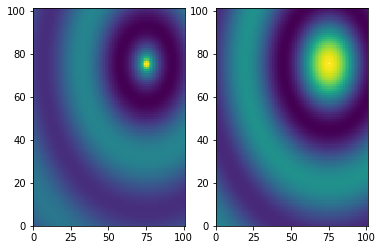

In [50]:
x0 = numpy.array([0.5, 0.5])
field = numpy.zeros(N**2, dtype=numpy.complex128)
dist = numpy.sqrt(numpy.sum((X - x0)**2, axis=1))
field += 1j/4*numpy.sqrt(omega)*hankel1(0, omega*dist)
field = field.reshape(N, N)

fig, ax = plt.subplots(1,2)
ax[0].pcolor(field.real)
ax[1].pcolor(field.imag)

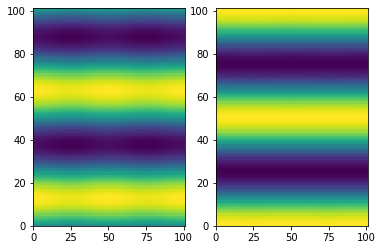

In [52]:
## Generate plane wave from point sources:

Npoints = 1000
x0 = numpy.vstack((numpy.linspace(-100, 100, Npoints), 2 * numpy.ones(Npoints))).T
field = numpy.zeros(N**2, dtype=numpy.complex128)

# TODO: vectorize this:
for x in x0:
  dist = numpy.sqrt(numpy.sum((X - x)**2, axis=1))
  field += 1j/4*numpy.sqrt(omega)*hankel1(0, omega*dist)

field = field.reshape(N, N)

fig, ax = plt.subplots(1,2)
ax[0].pcolor(field.real)
ax[1].pcolor(field.imag)